In [0]:
%pip install yfinance matplotlib PyPortfolioOpt seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/3.0 MB ? eta -:--:--
     ━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━ 1.3/3.0 MB 7.4 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 8.9 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached numpy-2.3.1-cp311-cp311-manylinux_2_28_aarch64.whl.metadata (62 kB)
  Installing build dependencie

#Portfolio Optimization using the Markowitz Efficient Frontier

In [0]:
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pypfopt import EfficientFrontier, risk_models, expected_returns


In [0]:
tickers = ['TCS.NS', 'HDFCBANK.NS', 'RELIANCE.NS', 'ITC.NS', 'TATASTEEL.NS',
           'BHARTIARTL.NS', 'ASIANPAINT.NS', 'MARUTI.NS', 'INFY.NS', 'TITAN.NS']

In [0]:
data = yf.download(tickers, start="2019-01-01", end="2024-12-31")
data = data['Close']  #Adjusted for he latst yfinance update where AdjCLose is directly shown and doesnt need to be calcualted separately

/home/spark-a393ac0f-a486-4988-acce-0d/.ipykernel/14046/command-6311661911248307-1839206675:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start="2019-01-01", end="2024-12-31")
[*********************100%***********************]  10 of 10 completed


In [0]:
print(data.columns)
data.head()

Index(['ASIANPAINT.NS', 'BHARTIARTL.NS', 'HDFCBANK.NS', 'INFY.NS', 'ITC.NS',
       'MARUTI.NS', 'RELIANCE.NS', 'TATASTEEL.NS', 'TCS.NS', 'TITAN.NS'],
      dtype='object', name='Ticker')


Ticker,ASIANPAINT.NS,BHARTIARTL.NS,HDFCBANK.NS,INFY.NS,ITC.NS,MARUTI.NS,RELIANCE.NS,TATASTEEL.NS,TCS.NS,TITAN.NS
Date,,,,,,,,,,
2019-01-01,1297.032227,282.769745,1011.295349,565.133301,219.315842,7080.273438,500.481506,42.175468,1666.739380,908.897034
2019-01-02,1308.143555,276.707245,1002.068054,568.532410,217.686661,6882.404785,493.963226,40.368240,1684.696411,912.961548
2019-01-03,1312.871948,277.459564,994.205811,568.617371,216.329010,6821.894531,487.869049,39.354233,1664.243530,912.031189
2019-01-04,1310.555176,285.380646,996.865662,561.734314,217.958206,6850.824219,490.503143,39.877590,1644.009155,909.337769
2019-01-07,1320.153442,287.593201,998.372192,570.784180,218.501221,6971.608887,493.226562,39.701775,1662.447510,924.616577


In [0]:
# Drop any rows with missing values first (important for accuracy)
data = data.dropna()

# Calculate daily percentage returns
returns = data.pct_change().dropna()
returns.head()

Ticker,ASIANPAINT.NS,BHARTIARTL.NS,HDFCBANK.NS,INFY.NS,ITC.NS,MARUTI.NS,RELIANCE.NS,TATASTEEL.NS,TCS.NS,TITAN.NS
Date,,,,,,,,,,
2019-01-02,0.008567,-0.021440,-0.009124,0.006015,-0.007428,-0.027946,-0.013024,-0.042850,0.010774,0.004472
2019-01-03,0.003615,0.002719,-0.007846,0.000149,-0.006237,-0.008792,-0.012337,-0.025119,-0.012140,-0.001019
2019-01-04,-0.001765,0.028549,0.002675,-0.012105,0.007531,0.004241,0.005399,0.013299,-0.012158,-0.002953
2019-01-07,0.007324,0.007753,0.001511,0.016111,0.002491,0.017631,0.005552,-0.004409,0.011215,0.016802
2019-01-08,0.003761,0.013233,-0.008323,-0.002456,0.009231,0.010520,-0.000091,0.012049,-0.002292,0.002224


##Annualised for portfolio Theory (252 annual trading days)

In [0]:
# Average daily returns
mean_daily_returns = returns.mean()

# Annualize them: multiply by 252 (trading days in a year)
annual_returns = mean_daily_returns * 252

# Covariance matrix (risk), annualized
cov_matrix = returns.cov() * 252

print("📈 Annualized Mean Returns (%):")
print((annual_returns * 100).round(2))

📈 Annualized Mean Returns (%):
Ticker
ASIANPAINT.NS    12.79
BHARTIARTL.NS    33.80
HDFCBANK.NS      12.86
INFY.NS          24.38
ITC.NS           15.82
MARUTI.NS        11.74
RELIANCE.NS      19.33
TATASTEEL.NS     26.79
TCS.NS           18.09
TITAN.NS         25.96
dtype: float64


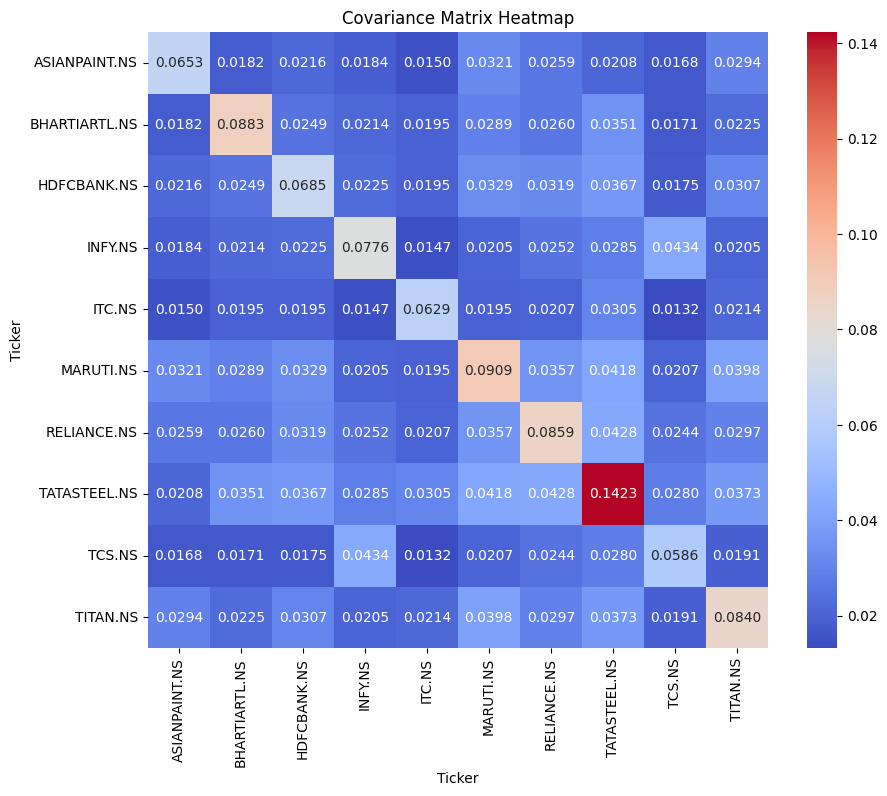

In [0]:
plt.figure(figsize=(10, 8))
sns.heatmap(cov_matrix, annot=True, fmt=".4f", cmap="coolwarm")
plt.title("Covariance Matrix Heatmap")
plt.show()

###Monte Carlo Simulations for 1M portfolios

In [0]:
num_portfolios = 1000000
num_assets = len(tickers)

results = np.zeros((3, num_portfolios))
weights_record = []

for i in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)
    weights_record.append(weights)

    portfolio_return = np.dot(weights, annual_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = portfolio_return / portfolio_volatility

    results[0, i] = portfolio_return
    results[1, i] = portfolio_volatility
    results[2, i] = sharpe_ratio

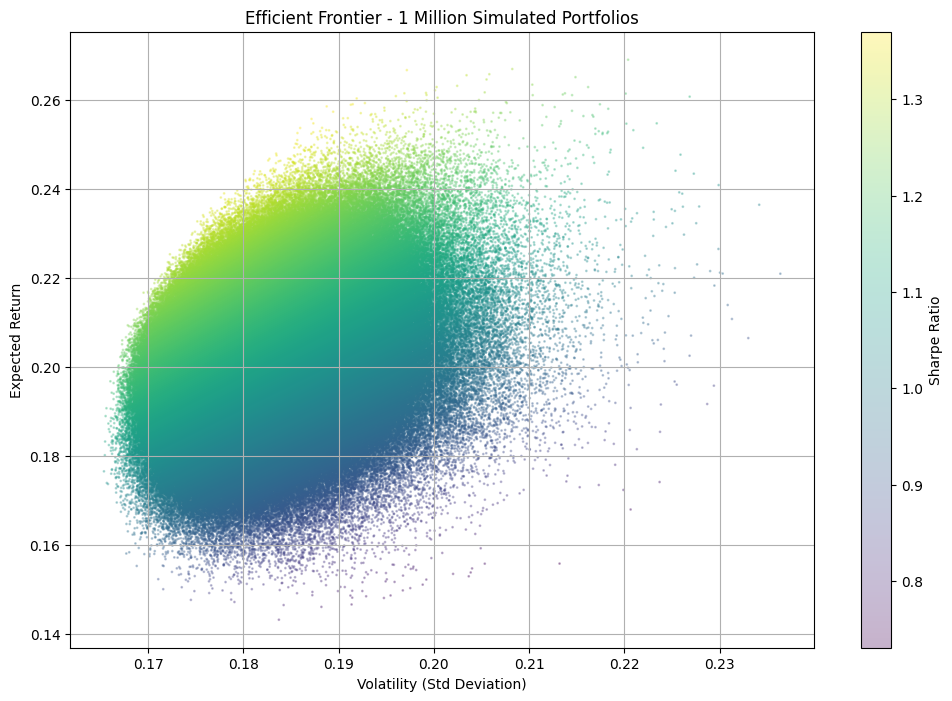

In [0]:
plt.figure(figsize=(12, 8))
plt.scatter(results[1, :], results[0, :], c=results[2, :], cmap='viridis', marker='o', s=1, alpha=0.3)
plt.xlabel('Volatility (Std Deviation)')
plt.ylabel('Expected Return')
plt.colorbar(label='Sharpe Ratio')
plt.title('Efficient Frontier - 1 Million Simulated Portfolios')
plt.grid(True)
plt.show()

## 🎯 Reducing Number of Simulated Portfolios from 1,000,000 to 100,000

> Initially, we simulated **1 million portfolios** to generate a highly detailed Efficient Frontier. While this offered rich insights, it resulted in:
- **Overplotting** in the visualization, making it hard to distinguish differences in Sharpe ratios.
- **Longer computation times** and higher memory usage, especially on a free Databricks cluster.

Therefore, we reduced the simulation size to **100,000 portfolios**, which strikes a balance between:
- **Visual clarity** in the Efficient Frontier plot.
- **Sufficient diversity** in portfolio weights and Sharpe ratios.
- **Efficient performance** within resource constraints.

This adjustment maintains analytical integrity while improving both computational efficiency and presentation quality.

In [0]:
num_portfolios = 100000
num_assets = len(tickers)

results = np.zeros((3, num_portfolios))
weights_record = []

for i in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)
    weights_record.append(weights)

    portfolio_return = np.dot(weights, annual_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = portfolio_return / portfolio_volatility

    results[0, i] = portfolio_return
    results[1, i] = portfolio_volatility
    results[2, i] = sharpe_ratio

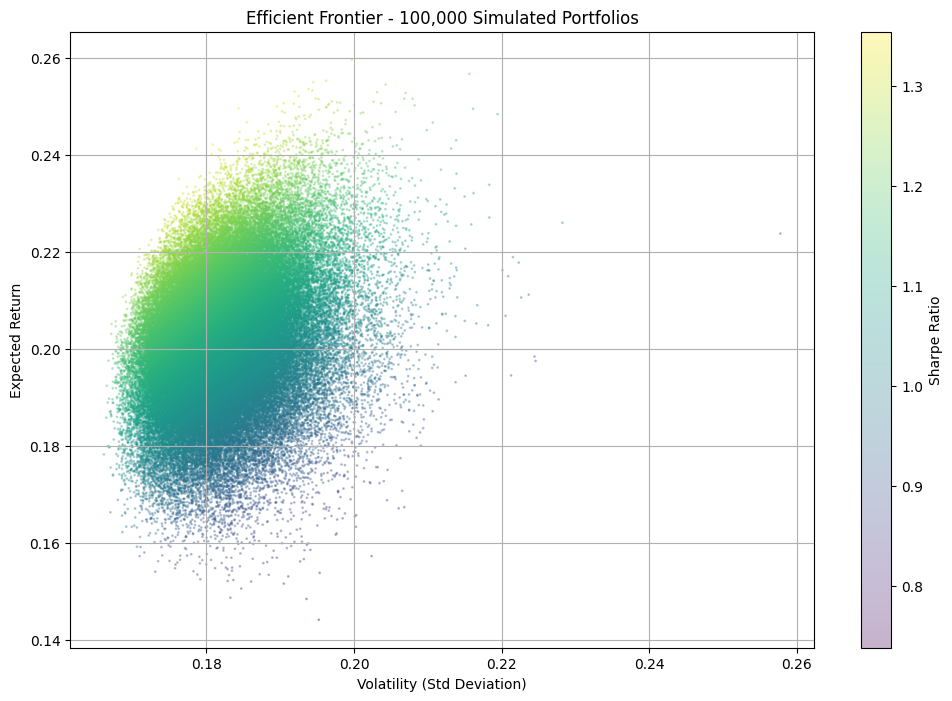

In [0]:
plt.figure(figsize=(12, 8))
plt.scatter(results[1, :], results[0, :], c=results[2, :], cmap='viridis', marker='o', s=1, alpha=0.3)
plt.xlabel('Volatility (Std Deviation)')
plt.ylabel('Expected Return')
plt.colorbar(label='Sharpe Ratio')
plt.title('Efficient Frontier - 100,000 Simulated Portfolios')
plt.grid(True)
plt.show()

In [0]:
# Estimate expected returns (annualized)
mu = expected_returns.mean_historical_return(data)

#Covariance Matrix
S = risk_models.sample_cov(data)

In [0]:
#Efficient Frontier
ef = EfficientFrontier(mu, S)

In [0]:
# Maximize Sharpe Ratio
optimal_weights = ef.max_sharpe()

# Clean the weights for readability
cleaned_weights = ef.clean_weights()
print("📊 Optimal Weights (Max Sharpe Portfolio):")
print(cleaned_weights)

📊 Optimal Weights (Max Sharpe Portfolio):
OrderedDict([('ASIANPAINT.NS', 0.0), ('BHARTIARTL.NS', 0.45343), ('HDFCBANK.NS', 0.0), ('INFY.NS', 0.22762), ('ITC.NS', 0.04158), ('MARUTI.NS', 0.0), ('RELIANCE.NS', 0.0), ('TATASTEEL.NS', 0.0), ('TCS.NS', 0.03413), ('TITAN.NS', 0.24324)])


In [0]:
#Portfolio Performance Matrix
performance = ef.portfolio_performance(verbose=True)

Expected annual return: 27.7%
Annual volatility: 20.5%
Sharpe Ratio: 1.35


In [0]:
# Weights to DataFrame
weights_df = pd.DataFrame.from_dict(cleaned_weights, orient='index', columns=['Weight'])
weights_df = weights_df[weights_df['Weight'] > 0]  # filter non-zero allocations
weights_df = weights_df.sort_values(by='Weight', ascending=False)
weights_df

,Weight
BHARTIARTL.NS,0.45343
TITAN.NS,0.24324
INFY.NS,0.22762
ITC.NS,0.04158
TCS.NS,0.03413


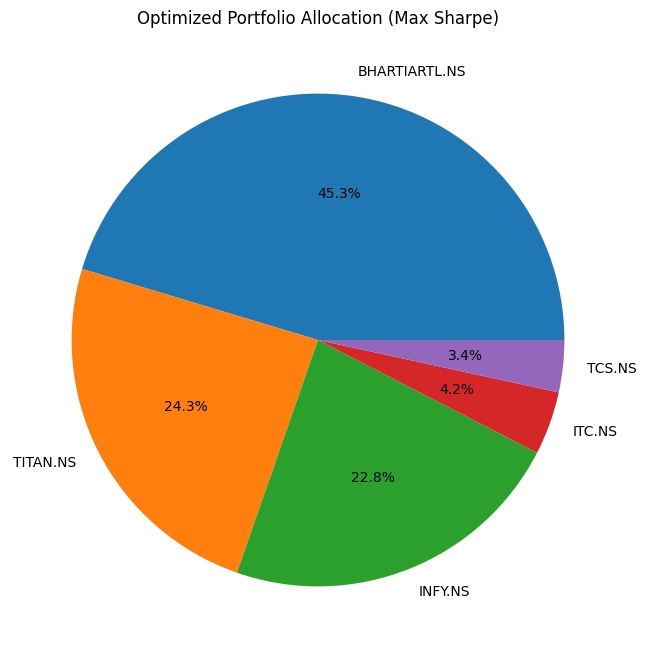

In [0]:
# Pie chart of asset weights
weights_df.plot.pie(y='Weight', autopct='%1.1f%%', figsize=(8, 8), legend=False)
plt.title('Optimized Portfolio Allocation (Max Sharpe)')
plt.ylabel('')
plt.show()

## 🧠 Optimized Portfolio (Max Sharpe Ratio)

The optimizer selected a portfolio with the following characteristics:

- ✅ **Expected Annual Return**: **27.7%**
- ✅ **Annual Volatility**: **20.5%**
- ✅ **Sharpe Ratio**: **1.35**

This means the portfolio offers a **strong risk-adjusted return**, balancing high returns with manageable volatility.

### ✅ Allocated Stocks and Weights:
| Stock           | Sector              | Weight    |
|------------------|-----------------------|-----------|
| BHARTIARTL.NS     | Telecom               | 45.3%     |
| TITAN.NS          | Consumer Durables     | 24.3%     |
| INFY.NS           | IT                    | 22.8%     |
| ITC.NS            | FMCG                  | 4.2%      |
| TCS.NS            | IT                    | 3.4%      |
| *Others*          | -                     | **0.0%**  |

- 🟡 The model **ignored 5 stocks entirely**: TATASTEEL, RELIANCE, MARUTI, HDFC Bank, Asian Paints — likely due to **low Sharpe ratios or high correlation** with selected assets.
- 🧪 The concentration in Bharti Airtel and Titan suggests strong **return-to-risk ratios** with relatively **low covariance** with others.


###Equally weighted portfolio

In [0]:
equal_weights = np.array([1/len(tickers)] * len(tickers))

In [0]:
equal_port_return = np.dot(equal_weights, mu)
equal_port_volatility = np.sqrt(np.dot(equal_weights.T, np.dot(S, equal_weights)))
equal_port_sharpe = equal_port_return / equal_port_volatility

print("📊 Equal Weight Portfolio:")
print(f"Expected Annual Return: {equal_port_return:.2%}")
print(f"Annual Volatility: {equal_port_volatility:.2%}")
print(f"Sharpe Ratio: {equal_port_sharpe:.2f}")

📊 Equal Weight Portfolio:
Expected Annual Return: 17.64%
Annual Volatility: 17.75%
Sharpe Ratio: 0.99


## ⚖️ Portfolio Strategy Comparison: Optimized vs Equal-Weighted

| Metric                | Optimized Portfolio (Max Sharpe) | Equal Weighted Portfolio |
|------------------------|-------------------------------|--------------------------|
| **Expected Return**    | 27.70%                        | 17.64%                   |
| **Volatility**         | 20.50%                        | 17.75%                   |
| **Sharpe Ratio**       | **1.35**                      | 0.99                     |

### 🔍 Insights:
- The **optimized portfolio** delivers **+10% higher expected return** than the naive equal-weight strategy.
- While volatility is slightly higher, the **Sharpe Ratio improvement (1.35 vs 0.99)** justifies the risk.
- This illustrates the core idea of **Modern Portfolio Theory (MPT)** — smart diversification leads to better risk-adjusted outcomes.


In [0]:
# Assign optimized portfolio metrics to variables
opt_return, opt_volatility, opt_sharpe = ef.portfolio_performance()


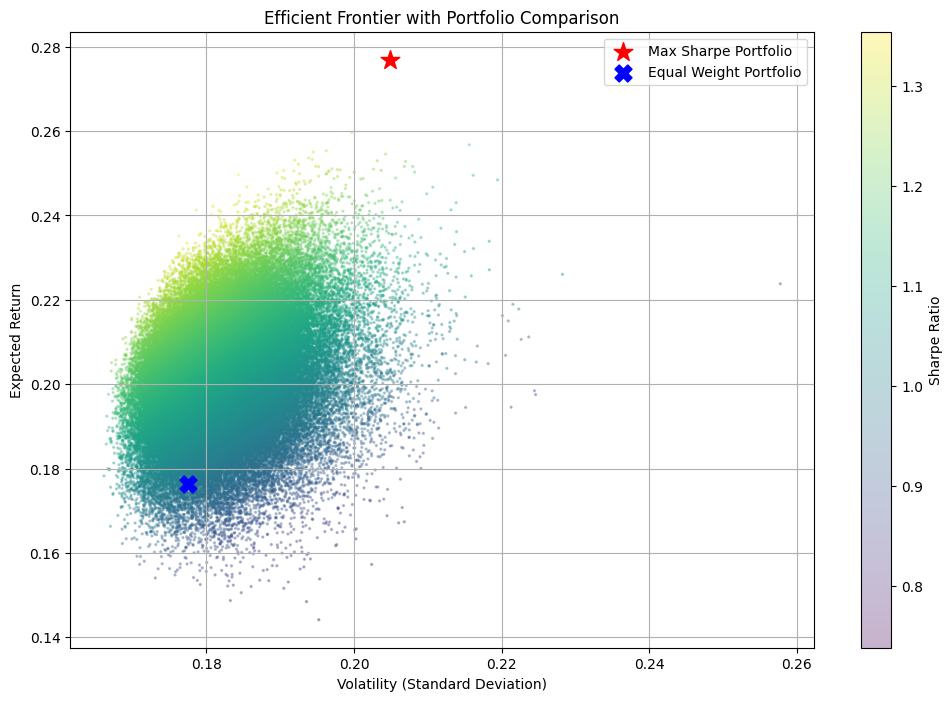

In [0]:
plt.figure(figsize=(12, 8))
plt.scatter(results[1, :], results[0, :], c=results[2, :], cmap='viridis', alpha=0.3, s=2)
plt.colorbar(label='Sharpe Ratio')

plt.scatter(opt_volatility, opt_return, marker='*', color='red', s=200, label='Max Sharpe Portfolio')
plt.scatter(equal_port_volatility, equal_port_return, marker='X', color='blue', s=150, label='Equal Weight Portfolio')

plt.xlabel('Volatility (Standard Deviation)')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier with Portfolio Comparison')
plt.legend()
plt.grid(True)
plt.show()
